In [13]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
import time
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from scipy.stats import kendalltau
from sklearn.metrics import cohen_kappa_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from sklearn.discriminant_analysis import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import torch

from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()



In [14]:
root_dir = "./"
# Input data directory to read training data from
input_dir = root_dir + "sample_data/"
# Reference data directory to read test labels from
reference_dir = root_dir + "sample_data/"
# Output data directory to write predictions to
output_dir = root_dir + "sample_result_submission"
# Program directory
program_dir = root_dir + "ingestion_program"
# Score directory
score_dir = root_dir + "scoring_program"
# Directory to read submitted submissions from
submission_dir = root_dir + "sample_code_submission"

In [15]:
sys.path.append(input_dir)
sys.path.append(reference_dir)
sys.path.append(output_dir)
sys.path.append(program_dir)
sys.path.append(submission_dir)

In [16]:
class Data():

  def __init__(self):

    self.df = None

    print("==========================================")
    print("Data")
    print("==========================================")

  def load_data(self):
    #  Load data from a CSV file into a Pandas DataFrame.
    print("[*] Loading Data")

    # data file path
    input_data_file = os.path.join(input_dir, 'input_data.csv')
    refer_data_file = os.path.join(reference_dir, 'reference_data.csv')

    # read data
    input_df = pd.read_csv(input_data_file)
    refer_df = pd.read_csv(refer_data_file)

    self.X_train = input_df.iloc[:, :-1].values
    self.y_train = input_df.iloc[:, -1].values

    self.X_test = refer_df.iloc[:, :-1].values
    self.y_test = refer_df.iloc[:, -1].values
    
  def get_train_data(self):
    return self.X_train, self.y_train
  
  def get_test_data(self):
    return self.X_test, self.y_test
  
  def show_data_stats(self):
    print("X_train shape: ", np.shape(self.X_train))
    print("y_train shape: ", np.shape(self.y_train))
    print("X_test shape: ", np.shape(self.X_test))
    print("y_test shape: ", np.shape(self.y_test))

In [17]:
# Initilaize data
data = Data()

Data


In [18]:
data.load_data()

[*] Loading Data


In [19]:
# get train test data
X_train, y_train = data.get_train_data()
X_test, y_test = data.get_test_data()

In [20]:

data.show_data_stats()

X_train shape:  (80524, 384)
y_train shape:  (80524,)
X_test shape:  (20132, 384)
y_test shape:  (20132,)


In [21]:
X= np.concatenate((X_train,X_test), axis=0)
y= np.concatenate((y_train,y_test), axis=0)

In [22]:
print(X.shape)
print(y.shape)

(100656, 384)
(100656,)


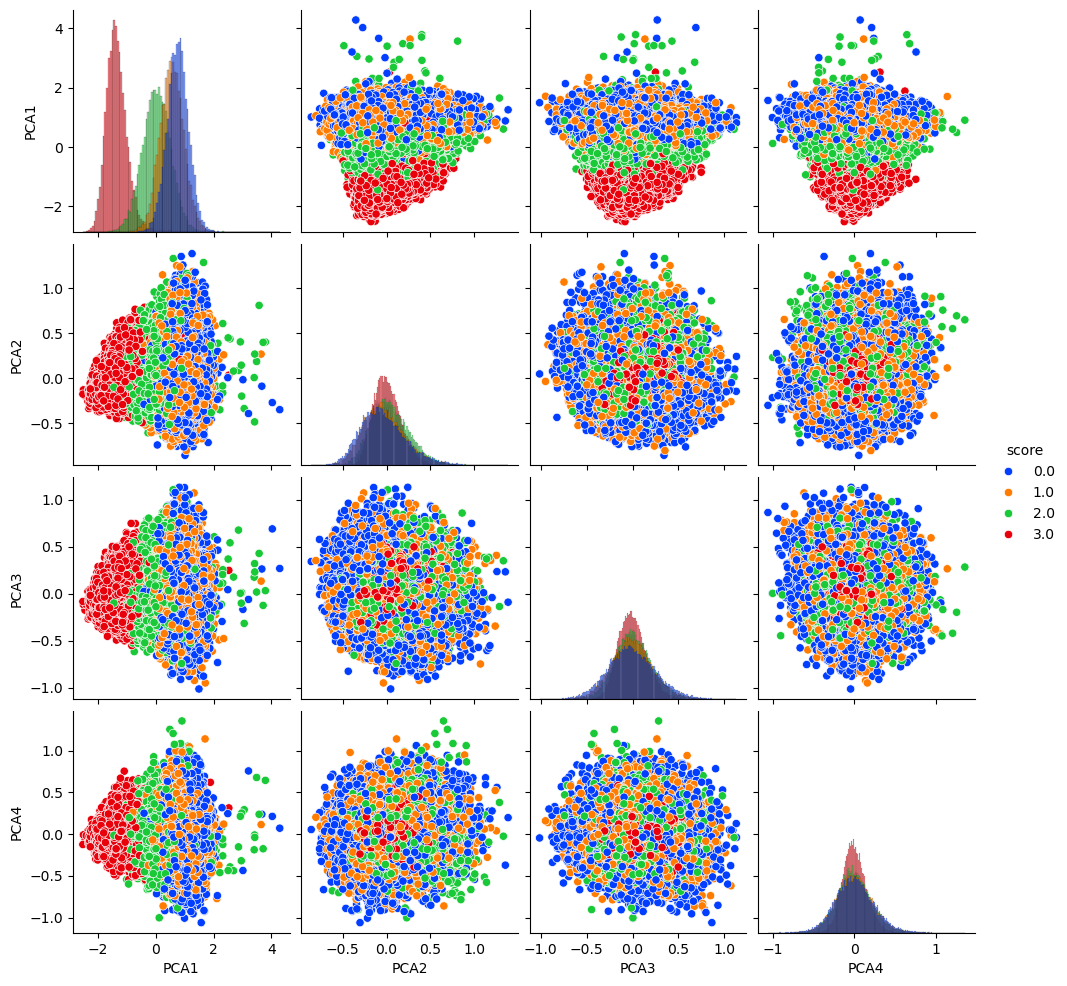

In [17]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=4)
components = pca.fit_transform(X)
pca_df= pd.DataFrame(components, columns=['PCA1','PCA2','PCA3','PCA4'])
pca_df['score']=y
pca_df
sns.pairplot(pca_df, hue="score", diag_kind="hist",palette="bright")
plt.show()

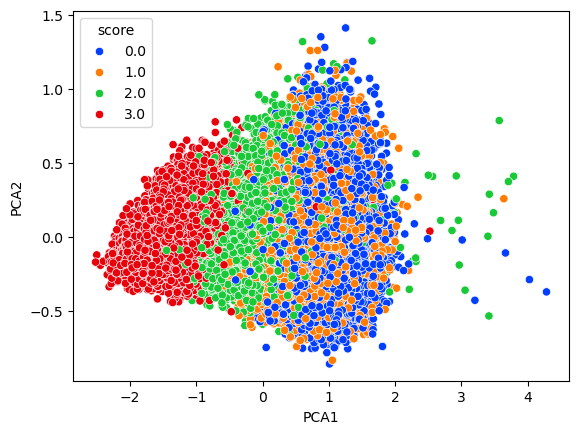

In [16]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
components = pca.fit_transform(X)
pca_df= pd.DataFrame(components, columns=['PCA1','PCA2'])
pca_df['score']=y
pca_df
sns.scatterplot(x='PCA1', y='PCA2', data=pca_df,hue="score",palette="bright")
plt.show()

<Axes: xlabel='PCA1', ylabel='PCA2'>

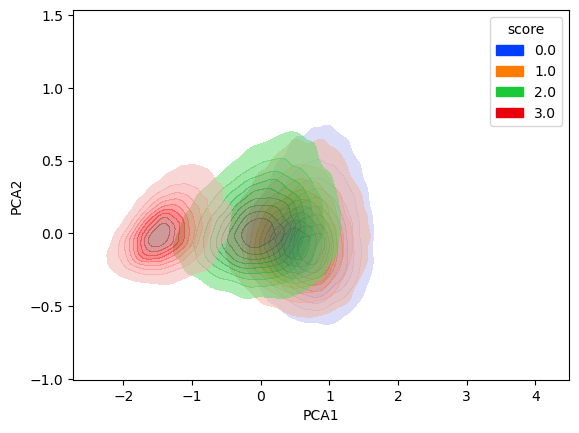

In [24]:
sns.kdeplot(
   data=pca_df, x="PCA1", y="PCA2", hue="score",
   fill=True, common_norm=False, palette="bright",
   alpha=.5, linewidth=0,
)

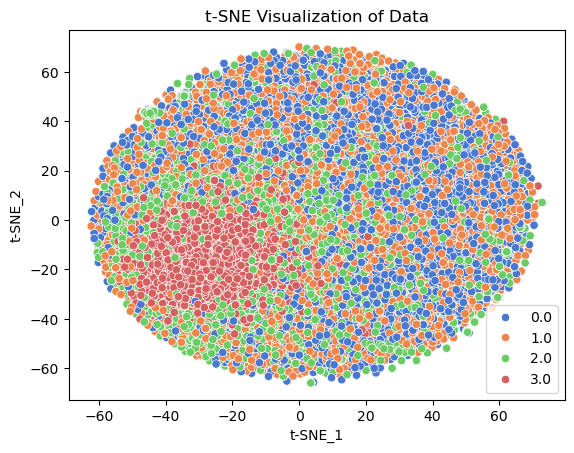

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

tsne_df= pd.DataFrame(X_tsne, columns=['t-SNE_1','t-SNE_2'])
tsne_df['score']=y
sns.scatterplot(x='t-SNE_1', y='t-SNE_2', data=tsne_df,hue="score",palette="muted")
plt.title('t-SNE Visualization of Data')
plt.legend()
plt.show()


<Axes: xlabel='t-SNE_1', ylabel='t-SNE_2'>

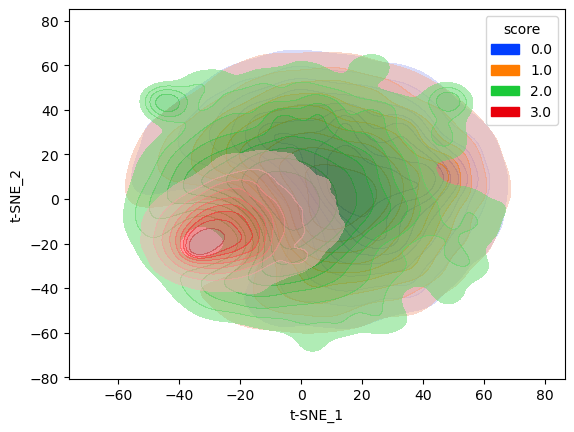

In [25]:
sns.kdeplot(
    x='t-SNE_1', y='t-SNE_2', data=tsne_df, hue="score",
   fill=True, common_norm=False, palette="bright",
   alpha=.5, linewidth=0,
)

In [23]:
import autosklearn.classification

In [25]:
import os

#Set TOKENIZERS_PARALLELISM to false
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [26]:
automl = autosklearn.classification.AutoSklearnClassifier(
    memory_limit=8192, 
    n_jobs=-1 ,
    time_left_for_this_task=3600,  # 1 hour
    per_run_time_limit=300,         # 5 minutes per model
)
automl.fit(X_train, y_train)
predictions = automl.predict(X_test)

[WARNING] [2024-02-14 21:47:12,585:Client-EnsembleBuilder] No runs were available to build an ensemble from


In [42]:
df_cv_results = pd.DataFrame(automl.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results

mean_test_score  rank_test_scores  mean_fit_time  \
135         0.681331                 1      35.452337   
101         0.678809                 2      38.881476   
139         0.678207                 3      35.597228   
147         0.672976                 4      16.862872   
143         0.670116                 5      23.817117   
..               ...               ...            ...   
42          0.000000                70       3.158229   
40          0.000000                70     301.768110   
38          0.000000                70       3.461927   
35          0.000000                70       8.597848   
154         0.000000                70       5.982330   

                                                params   status  budgets  \
135  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
101  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
139  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
147  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
143  {'balancing:strategy': 'weighting', 'classifie...  Success      0.0   
..                                                 ...      ...      ...   
42   {'balancing:strategy': 'weighting', 'classifie...    Crash      0.0   
40   {'balancing:strategy': 'none', 'classifier:__c...  Timeout      0.0   
38   {'balancing:strategy': 'none', 'classifier:__c...    Crash      0.0   
35   {'balancing:strategy': 'none', 'classifier:__c...    Crash      0.0   
154  {'balancing:strategy': 'weighting', 'classifie...  Timeout      0.0   

    param_balancing:strategy param_classifier:__choice__  \
135                weighting                         qda   
101                weighting                         qda   
139                weighting                         qda   
147                weighting                         lda   
143                weighting                         lda   
..                       ...                         ...   
42                 weighting                    adaboost   
40                      none                  libsvm_svc   
38                      none           gradient_boosting   
35                      none         k_nearest_neighbors   
154                weighting                         lda   

    param_data_preprocessor:__choice__ param_feature_preprocessor:__choice__  \
135                       feature_type           select_rates_classification   
101                       feature_type           select_rates_classification   
139                       feature_type           select_rates_classification   
147                       feature_type           select_rates_classification   
143                       feature_type           select_rates_classification   
..                                 ...                                   ...   
42                        feature_type           select_rates_classification   
40                        feature_type                              fast_ica   
38                        feature_type                                   pca   
35                        feature_type           select_rates_classification   
154                       feature_type           select_rates_classification   

     ...  \
135  ...   
101  ...   
139  ...   
147  ...   
143  ...   
..   ...   
42   ...   
40   ...   
38   ...   
35   ...   
154  ...   

    param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max  \
135                                                NaN                                         
101                                                NaN                                         
139                                               0.75                                         
147                                                NaN                                         
143                                                NaN                                         
..  

In [44]:
print(automl.leaderboard())

          rank  ensemble_weight                type      cost    duration
model_id                                                                 
137          1             0.04                 qda  0.318669   35.452337
141          2             0.02                 qda  0.321793   35.597228
149          3             0.04                 lda  0.327024   16.862872
142          4             0.04                 lda  0.329884   29.406780
119          5             0.06                 qda  0.339480   70.217733
148          6             0.02                 lda  0.344523   39.152705
68           7             0.06         extra_trees  0.344673   95.874843
77           8             0.02         extra_trees  0.346404  198.641478
132          9             0.02       random_forest  0.348286  275.147012
135         10             0.04         extra_trees  0.348436  280.708415
81          11             0.02         extra_trees  0.348587  127.004123
80          12             0.06       

In [28]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: 113d8d05-cb7a-11ee-8f5b-080027ec2c70
  Metric: accuracy
  Best validation score: 0.681331
  Number of target algorithm runs: 155
  Number of successful target algorithm runs: 69
  Number of crashed target algorithm runs: 44
  Number of target algorithms that exceeded the time limit: 27
  Number of target algorithms that exceeded the memory limit: 15



In [32]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.60      0.68      0.64      5075
         1.0       0.50      0.43      0.47      5163
         2.0       0.70      0.67      0.69      4858
         3.0       0.94      0.97      0.95      5036

    accuracy                           0.69     20132
   macro avg       0.68      0.69      0.68     20132
weighted avg       0.68      0.69      0.68     20132



In [34]:
tau, _ = kendalltau(y_test, predictions)
tau

0.7657938890325207

In [31]:
import PipelineProfiler

profiler_data= PipelineProfiler.import_autosklearn(automl)
PipelineProfiler.plot_pipeline_matrix(profiler_data)

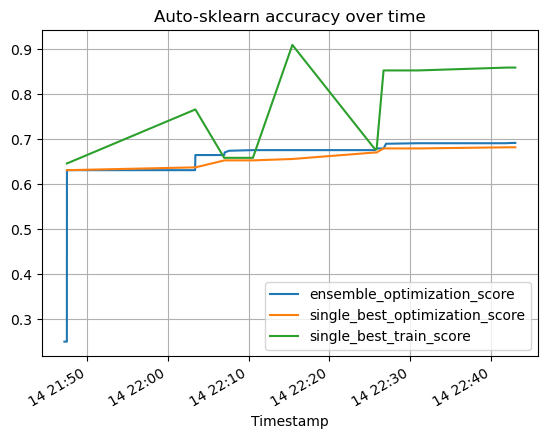

In [46]:
poT = automl.performance_over_time_
poT.plot(
    x="Timestamp",
    kind="line",
    legend=True,
    title="Auto-sklearn accuracy over time",
    grid=True,
)
plt.show()

In [47]:
import joblib
file_name='automl_classifier'
joblib.dump(automl,file_name)

['automl_classifier']